# Initialize

In [1]:
!pip install torchinfo
!pip install optuna
!pip install braindecode
!pip install retry

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/24W/EC ENGR C147/Project/prepare_data.py' .
!cp '/content/drive/MyDrive/24W/EC ENGR C147/Project/prepare_frequency_data.py' .
!cp '/content/drive/MyDrive/24W/EC ENGR C147/Project/models/Transformer.py' models/.
!cp -r '/content/drive/MyDrive/24W/EC ENGR C147/Project/utils' .
!cp -r '/content/drive/MyDrive/24W/EC ENGR C147/Project/data' .

## Begin from here if not using Google Colab

In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchinfo import summary

from models.Transformer import ConvViTforEEG
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train

In [5]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [6]:
%load_ext autoreload
%autoreload 2

## Constants

In [7]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [8]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [9]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [10]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [11]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [12]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [13]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

In [14]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [15]:
test_model = ConvViTforEEG(input_dim=(22, 750),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)
test_model.forward(torch.rand(2, 22, 750))
summary(test_model, input_size=(1, 22, 750), device=DEVICE)

Layer (type:depth-idx)                        Output Shape              Param #
ConvViTforEEG                                 [1, 4]                    6,144
├─Sequential: 1-1                             [1, 40, 1, 187]           --
│    └─Conv2d: 2-1                            [1, 20, 22, 751]          1,300
│    └─BatchNorm2d: 2-2                       [1, 20, 22, 751]          40
│    └─ELU: 2-3                               [1, 20, 22, 751]          --
│    └─Conv2d: 2-4                            [1, 40, 1, 751]           1,800
│    └─BatchNorm2d: 2-5                       [1, 40, 1, 751]           80
│    └─ELU: 2-6                               [1, 40, 1, 751]           --
│    └─AvgPool2d: 2-7                         [1, 40, 1, 187]           --
│    └─Dropout: 2-8                           [1, 40, 1, 187]           --
├─Linear: 1-2                                 [1, 94, 64]               5,184
├─TransformerEncoder: 1-3                     [1, 95, 64]               --
│    └─M

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [16]:
raw_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="raw.pt",
    n_epochs=200,
    show_progress_bar=False,
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cuda
[Epoch 0] val_acc=0.275148 train_acc=0.260551 val_loss=0.024602 train_loss=0.021874
Validation loss decreased (inf --> 0.024602).  Saving model ...
[Epoch 1] val_acc=0.295858 train_acc=0.279685 val_loss=0.024446 train_loss=0.021794
Validation loss decreased (0.024602 --> 0.024446).  Saving model ...
[Epoch 2] val_acc=0.301775 train_acc=0.306134 val_loss=0.024136 train_loss=0.021580
Validation loss decreased (0.024446 --> 0.024136).  Saving model ...
[Epoch 3] val_acc=0.355030 train_acc=0.364097 val_loss=0.023219 train_loss=0.021237
Validation loss decreased (0.024136 --> 0.023219).  Saving model ...
[Epoch 4] val_acc=0.369822 train_acc=0.415869 val_loss=0.023388 train_loss=0.020747
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.393491 train_acc=0.442881 val_loss=0.023337 train_loss=0.020429
EarlyStopping counter: 2 out of 30
[Epoch 6] val_acc=0.452663 train_acc=0.473832 val_loss=0.022192 train_loss=0.020168
Validation loss decreased (0.023219 --> 0.022192).  

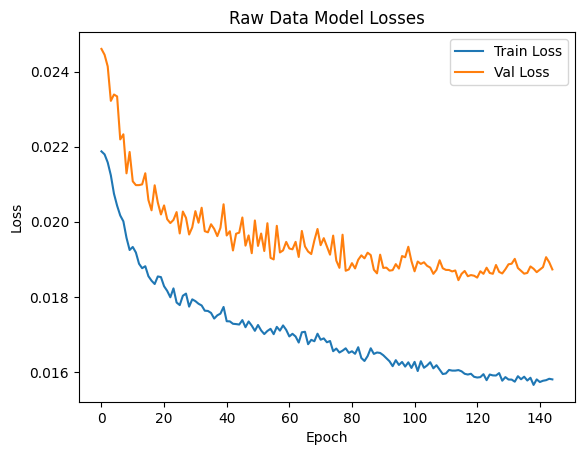

In [17]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

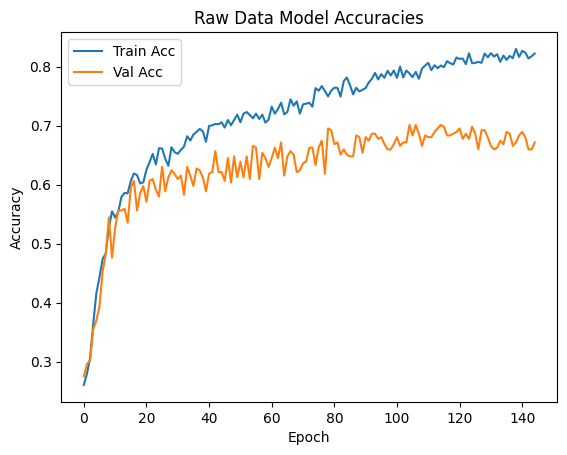

In [18]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
# Load best model and test
raw_model = torch.load("models/cnn_trans/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(20, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, o

In [20]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.6727


In [21]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.5200


## Subject 1 Only    

In [22]:
sub1_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="sub1.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.236842 train_acc=0.241206 val_loss=0.036442 train_loss=0.028079
Validation loss decreased (inf --> 0.036442).  Saving model ...
[Epoch 1] val_acc=0.236842 train_acc=0.241206 val_loss=0.036556 train_loss=0.028123
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.210526 train_acc=0.221106 val_loss=0.036582 train_loss=0.028361
EarlyStopping counter: 2 out of 30
[Epoch 3] val_acc=0.263158 train_acc=0.271357 val_loss=0.036467 train_loss=0.027696
EarlyStopping counter: 3 out of 30
[Epoch 4] val_acc=0.236842 train_acc=0.261307 val_loss=0.036440 train_loss=0.028000
Validation loss decreased (0.036442 --> 0.036440).  Saving model ...
[Epoch 5] val_acc=0.236842 train_acc=0.216080 val_loss=0.036508 train_loss=0.027883
EarlyStopping counter: 1 out of 30
[Epoch 6] val_acc=0.236842 train_acc=0.236181 val_loss=0.036650 train_loss=0.027817
EarlyStopping counter: 2 out of 30
[Epoch 7] val_acc=0.236842 train_acc=0.261307 val_loss=0.036826 train_loss=0.027756
E

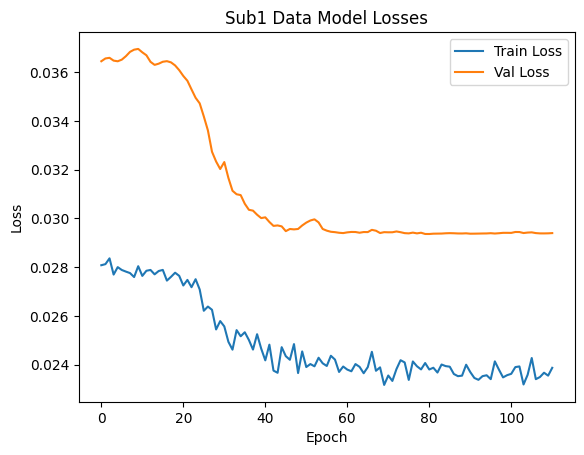

In [23]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

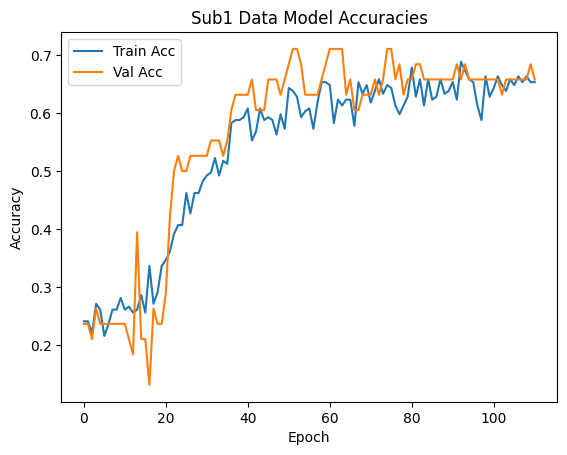

In [24]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [25]:
# Load best model and test
sub1_model = torch.load("models/cnn_trans/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(20, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

In [26]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.5400


In [27]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.3318


## Frequency Filtering Data

In [28]:
freq_model = ConvViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/cnn_trans",
    cp_filename="freq.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: cuda
[Epoch 0] val_acc=0.263314 train_acc=0.256612 val_loss=0.024583 train_loss=0.021891
Validation loss decreased (inf --> 0.024583).  Saving model ...
[Epoch 1] val_acc=0.269231 train_acc=0.263365 val_loss=0.024656 train_loss=0.021833
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.272189 train_acc=0.303883 val_loss=0.024518 train_loss=0.021706
Validation loss decreased (0.024583 --> 0.024518).  Saving model ...
[Epoch 3] val_acc=0.266272 train_acc=0.299944 val_loss=0.024622 train_loss=0.021677
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.292899 train_acc=0.307822 val_loss=0.024300 train_loss=0.021637
Validation loss decreased (0.024518 --> 0.024300).  Saving model ...
[Epoch 5] val_acc=0.292899 train_acc=0.301069 val_loss=0.024228 train_loss=0.021552
Validation loss decreased (0.024300 --> 0.024228).  Saving model ...
[Epoch 6] val_acc=0.307692 train_acc=0.335397 val_loss=0.023958 train_loss=0.021361
Validation loss decreased (0.024228 --> 0.023958).  

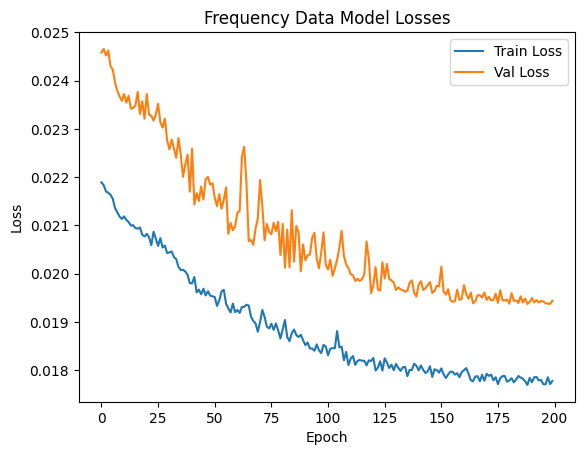

In [29]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

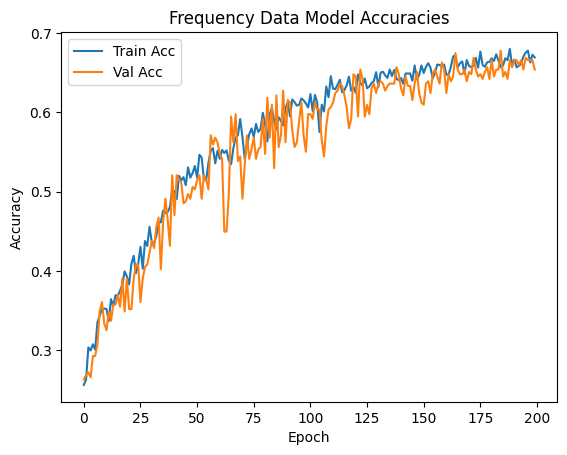

In [30]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [31]:
# Load best model and test
freq_model = torch.load("models/cnn_trans/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ConvViTforEEG(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(20, 40, kernel_size=(22, 1), stride=(1, 1), groups=10)
    (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (7): Dropout(p=0.3, inplace=False)
  )
  (lin_emb): Linear(in_features=80, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

In [32]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.6072


## Time Series

In [33]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [34]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    print(f"Training for time slots: {ts}...")

    train_data, valid_data, test_data = get_time_series_dataloader(ts)

    time_model = ConvViTforEEG(input_dim=(22, ts),
                      out_dim=4,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=2,
                      device=DEVICE).to(DEVICE)

    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=20,
        cp_path="models/cnn_trans",
        cp_filename=f"time_{ts}.pt",
        n_epochs=150,
        show_progress_bar=False,
        verbose=False,
    )

    # Load best model and test
    time_model = torch.load(f"models/cnn_trans/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()

    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)

    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)

    print(f"Time slots: {ts}, Valid Acc: {valid_acc[ts]:.4f}, Test Acc: {test_acc[ts]:.4f}")

Training for time slots: 50...
Using device: cuda
Time slots: 50, Valid Acc: 0.4172, Test Acc: 0.4131
Training for time slots: 100...
Using device: cuda
Time slots: 100, Valid Acc: 0.5473, Test Acc: 0.5034
Training for time slots: 150...
Using device: cuda
Time slots: 150, Valid Acc: 0.5621, Test Acc: 0.5395
Training for time slots: 200...
Using device: cuda
Time slots: 200, Valid Acc: 0.5976, Test Acc: 0.5643
Training for time slots: 250...
Using device: cuda
Time slots: 250, Valid Acc: 0.6391, Test Acc: 0.6411
Training for time slots: 500...
Using device: cuda
Time slots: 500, Valid Acc: 0.7130, Test Acc: 0.6637
Training for time slots: 750...
Using device: cuda
Time slots: 750, Valid Acc: 0.6568, Test Acc: 0.5869
Training for time slots: 1000...
Using device: cuda
Time slots: 1000, Valid Acc: 0.6893, Test Acc: 0.6388


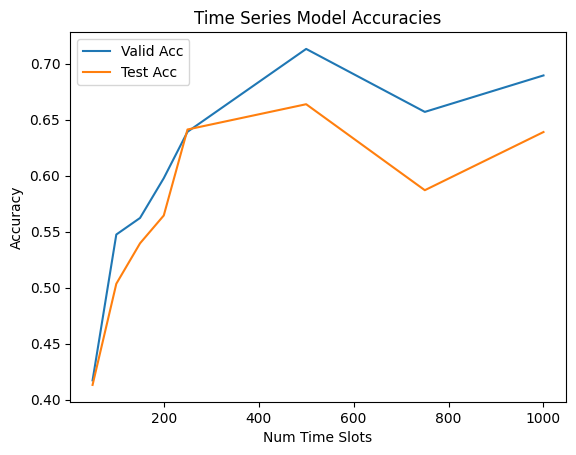

In [35]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()